# <span style="color:darkblue"> Laboratorio di Simulazione Numerica </span>
#### <span style="color:darkred">  Andrea Sala - Settembre 2020</span>
# <span style="color:darkgreen">  Esercitazione 3</span>

## Esercizio 3.1
By using the following parameters: 
- asset price at $t=0$: $S(0)=100$
- delivery time: $T=1$
- strike price: $K=100$
- risk-free interest rate: $r=0.1$
- volatility: $\sigma=0.25$

compute at time $t=0$ **via Monte Carlo** the European call-option price, $C[S(0),0]$, and put-option price, $P[S(0),0]$:

1. <span style="color:red"> By sampling **directly** the final asset price $S(T)$</span> for a $GBM(r,\sigma^2)$
2. <span style="color:red"> By sampling the discretized $GBM(r,\sigma^2)$ path of the asset price</span> 
dividing $[0,T]$ in $10^2$ time intervals: $S(0)$, $S(t_1)$, $S(t_2)$, ... up to $S(t_{100}=T=1)$

Il codice calcola l'andamento dei prezzi di opzioni finanziarie assumendo che la funzione prezzo $S(t)$ segua un Moto Browniano Geometrico $GBM(r,\sigma^2)$ con drift $r$ e volatilità $\sigma$. 
Le opzioni simulate nel codice sono opzioni europee, ovvero quelle in cui il venditore (*writer*) garantisce al compratore (*holder*) il diritto di comprare (**call**) o vendere (**put**) un oggetto con prezzo $S(t)$ ad un qualsiasi tempo t, ad un prezzo $K$ pattuito precedentemente detto *strike price*. Nel prezzare le opzioni finanziarie bisogna inoltre aggiugnere un fattore di sconto $e^{-rT}$ a causa dell'interesse che un eventuale deposito in banca avrebbe garantito.

Si lavora inoltre sotto le assunzioni della Teoria di Black-Scholes, che prevede un mercato infinitamente liquido ed efficiente, e che i prezzi delle opzioni seguano $GBM$ con parametri $r$, $\sigma$, $\mu$ costanti. In questo modo è possibile ricavare una soluzione analitica per il generico tempo $t>T$, come verrà fatto alla fine per confrontare i risultati ottenuti.


Per simulare con metodi Monte Carlo questi prezzi, è stato sufficiente generare un numero $N(0,T)$ distribuito secondo una distribuzione normale con valor medio $0$ e deviazione standard $T$, e con questo calcolare $$S(T)=S(0)e^{\left[(r-0.5\sigma^2)T + \sigma N(0,T)\right]} \qquad \quad (*)$$

Una volta ricavato $S(t)$ si ricavano facilmente $C[S(0),0]$ e $P[S(0),0]$ moltiplicando $e^{-rT}$ per il profitto a t=T. Il profitto si calcola intuitivamente come $\max[0,S(T)-K]$ per la call option e come $\max[0,K-S(T)]$ per la put option. Questo è il significato di campionare *direttamente* il prezzo finale. Il tutto è ovviamente stato eseguito $M=10^5$ volte e diviso in blocchi grazie all'implementazione della funzione `BlockMyData`.

In [2]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.special import erf
%config InlineBackend.figure_format = 'retina'

M=100000
N=250
L=M/N
x=np.arange(N)

S0 = 100.
K = 100.
T = 1.
r = 0.1
sigma = 0.25
t=0

Per controllare l'esattezza delle simulazioni calcolo la soluzione analitica per entrambe le opzioni, e la inserisco nel grafico dei risultati sperimentali.

In [3]:
def N(x):
    return 0.5 * (1. + erf(x / np.lib.scimath.sqrt(2.)))

def black_scholes(S0, K, T, r, sigma):
    d1 = 1./(sigma * np.lib.scimath.sqrt(T)) * (np.lib.scimath.log(S0 / K) + (r + (sigma**2) / 2.) * T)
    d2 = d1 - sigma * np.lib.scimath.sqrt(T)
    C = S0 * N(d1) - K * np.exp(-r * T) * N(d2)
    P = S0 *(N(d1) - 1.) - K * np.exp(-r * T) * (N(d2)-1.)
    return C, P

call, put = black_scholes(S0, K, T, r, sigma)
print("call: ", call, "     put: ", put)
    

call:  14.975790778311286      put:  5.4595325819072364


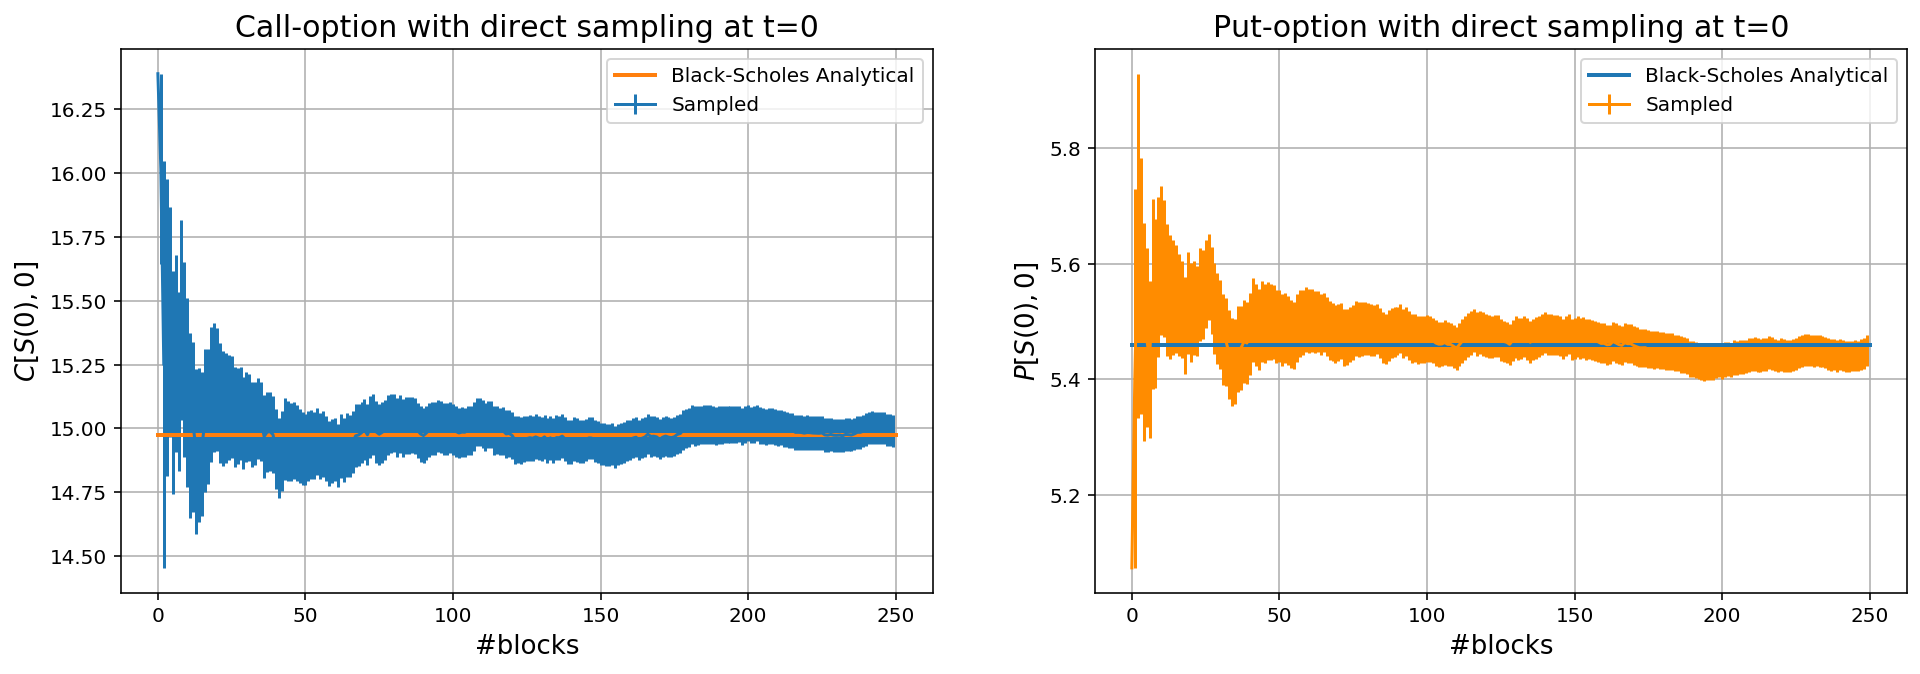

In [8]:
C, errC, P, errP = np.loadtxt("direct.out", usecols=(0,1,2,3), delimiter=' , ', unpack=True)

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].errorbar(x,C,xerr=None,yerr=errC, label='Sampled')
axs[0].plot([0,250], [call,call], linewidth=2, label='Black-Scholes Analytical')
axs[0].set_title('Call-option with direct sampling at t=0', fontsize=15)
axs[0].set_ylabel('$C[S(0),0]$',fontsize=13)


axs[1].errorbar(x,P,xerr=None,yerr=errP, color='darkorange', label='Sampled')
axs[1].plot([0,250], [put,put], linewidth=2, label='Black-Scholes Analytical')
axs[1].set_title('Put-option with direct sampling at t=0', fontsize=15)
axs[1].set_ylabel('$P[S(0),0]$',fontsize=13)

for ax in axs.flat:
    ax.set_xlabel('#blocks', fontsize=13)
    ax.grid(True)
    ax.legend()


plt.show()



Osservo che i valori analitici confermano i risultati ottenuti con la simulazione Monte Carlo.

La seconda parte del codice prevede invece il campionamento di un $GBM$ in modo discreto. Per fare questo ho suddiviso l'intervallo $[0,T]$ in 100 sottointervalli e ho calcolato la funzione S per ogni sottointervallo. Essendo questo un processo di Wiener, per calcolare $S(t_i)$ è necessario conoscere $S(t_{i-1})$ e quindi a partire da $S(0)$ ho calcolato tutti gli $S(t_i)$ fino ad arrivare alla quantità desiderata $S(T)$.
Il processo è formalmente identico, con appunto l'eccezione che $S(T)$ viene ricavata generando ogni volta una nuova variabile gaussiana $Z$ e aggiornando la variabile $S$ con la relazione $(*)$.

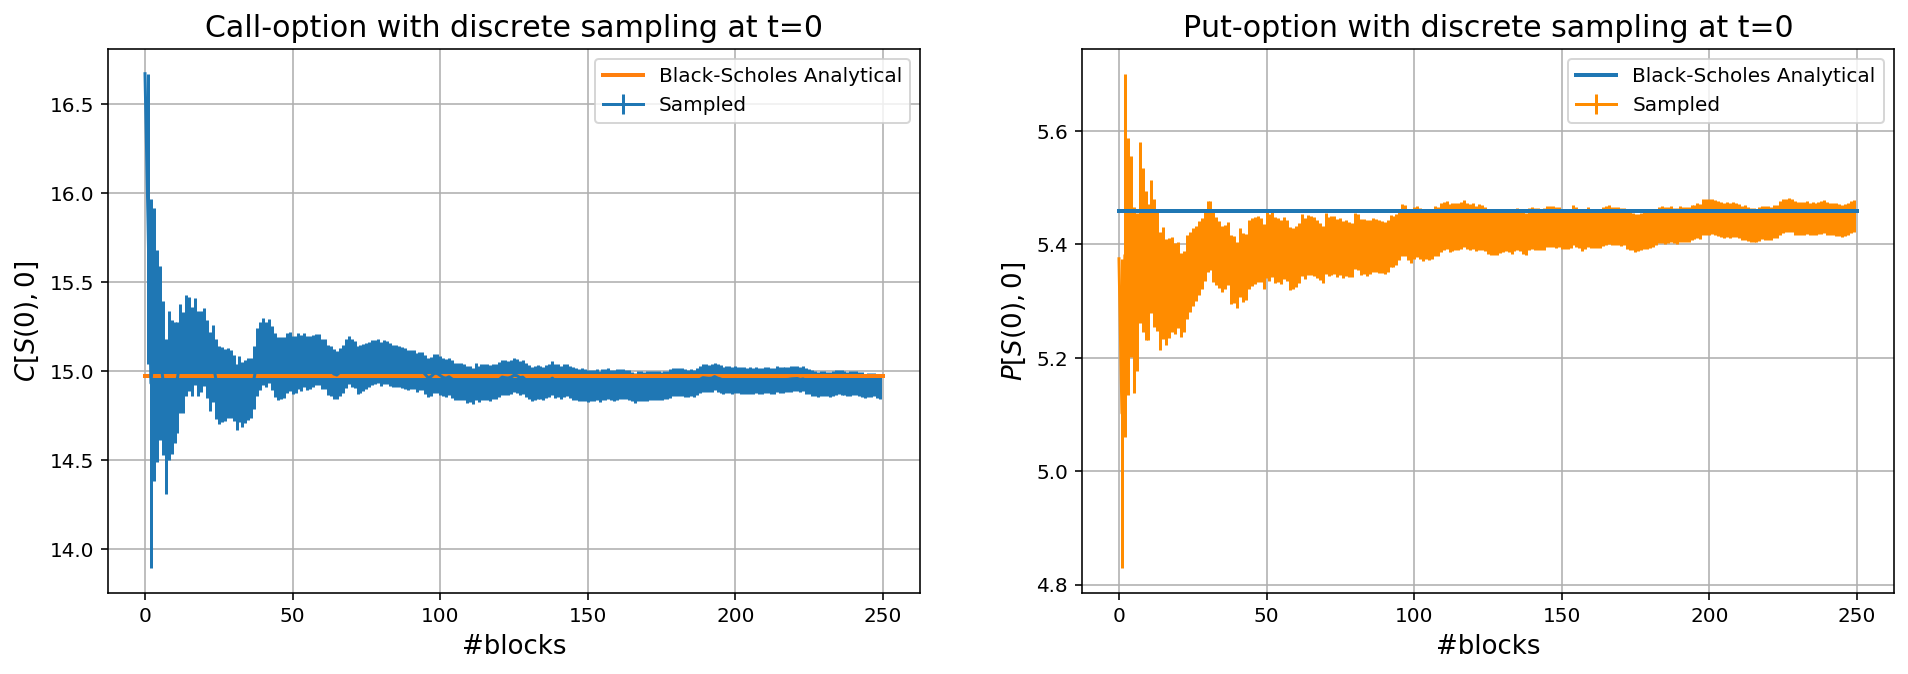

In [12]:
C, errC, P, errP = np.loadtxt("discrete.out", usecols=(0,1,2,3), delimiter=' , ', unpack=True)

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].errorbar(x,C,xerr=None,yerr=errC, label='Sampled')
axs[0].plot([0,250], [call,call], linewidth=2, label='Black-Scholes Analytical')
axs[0].set_title('Call-option with discrete sampling at t=0', fontsize=15)
axs[0].set_ylabel('$C[S(0),0]$',fontsize=13)


axs[1].errorbar(x,P,xerr=None,yerr=errP, color='darkorange', label='Sampled')
axs[1].set_title('Put-option with discrete sampling at t=0', fontsize=15)
axs[1].plot([0,250], [put,put], linewidth=2, label='Black-Scholes Analytical')
axs[1].set_ylabel('$P[S(0),0]$',fontsize=13)

for ax in axs.flat:
    ax.set_xlabel('#blocks', fontsize=13)
    ax.grid(True)
    ax.legend()


plt.show()


Si osserva che la convergenza è la stessa del caso di campionamento diretto, ma con errori più piccoli. Confrontando i risultati con le soluzioni analitiche, si osserva che i risultati della simulazione sono accettabili entro una deviazione standard e possiamo dunque confermare che il codice predice correttamente l'andamento dei prezzi di queste due opzioni. 